[INFO] FAST sample: 86335 rows (from 431675)

=== Validation Set ===
                  Target     R2       RMSE        MAE
voltage_rise_time_pulse1 0.9706 6.8951e-10 3.3858e-10
voltage_rise_time_pulse2 0.8798 1.5324e-09 7.5896e-10
voltage_fall_time_pulse1 0.9989 2.2936e-10 1.4896e-10
voltage_fall_time_pulse2 0.9989 2.2814e-10 1.4807e-10
current_rise_time_pulse1 0.9138 1.3787e-08 7.0670e-09
current_rise_time_pulse2 0.8949 8.6563e-09 4.1831e-09
current_fall_time_pulse1 0.9893 1.3397e-09 7.7236e-10
current_fall_time_pulse2 0.9895 1.3231e-09 7.6181e-10
       overshoot_pulse_1 0.9718 2.2704e+00 1.6829e+00
       overshoot_pulse_2 0.9318 6.9451e+00 5.2804e+00
      undershoot_pulse_1 0.9682 2.3977e+00 1.6786e+00
      undershoot_pulse_2 0.9687 2.3794e+00 1.6730e+00
   ringing_frequency_MHz 0.9980 1.4378e+00 1.0356e+00
R2_avg          0.9595
RMSE_avg    2.2680e+00
MAE_avg     8.7311e-01
dtype: object
Train Time (s): 20.1482
Predict Time (ms/sample): 0.0193

=== Test Set ===
                 

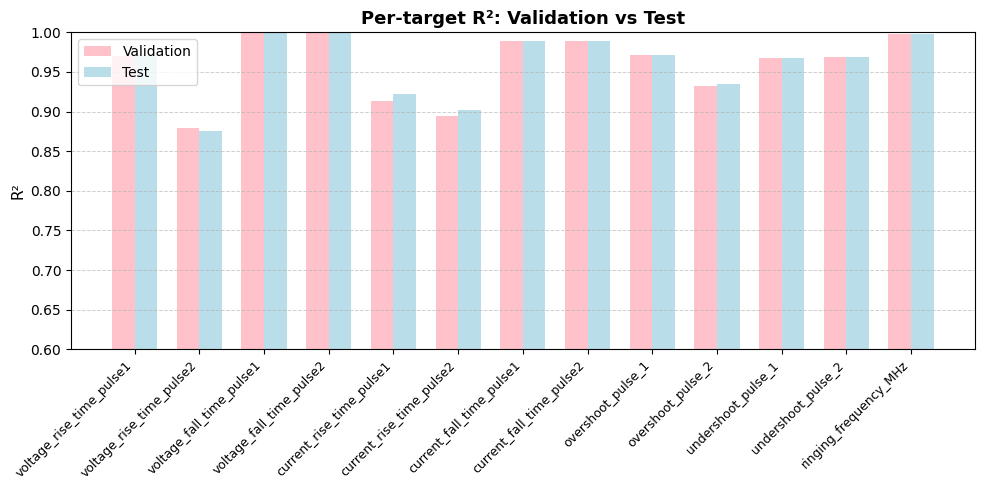

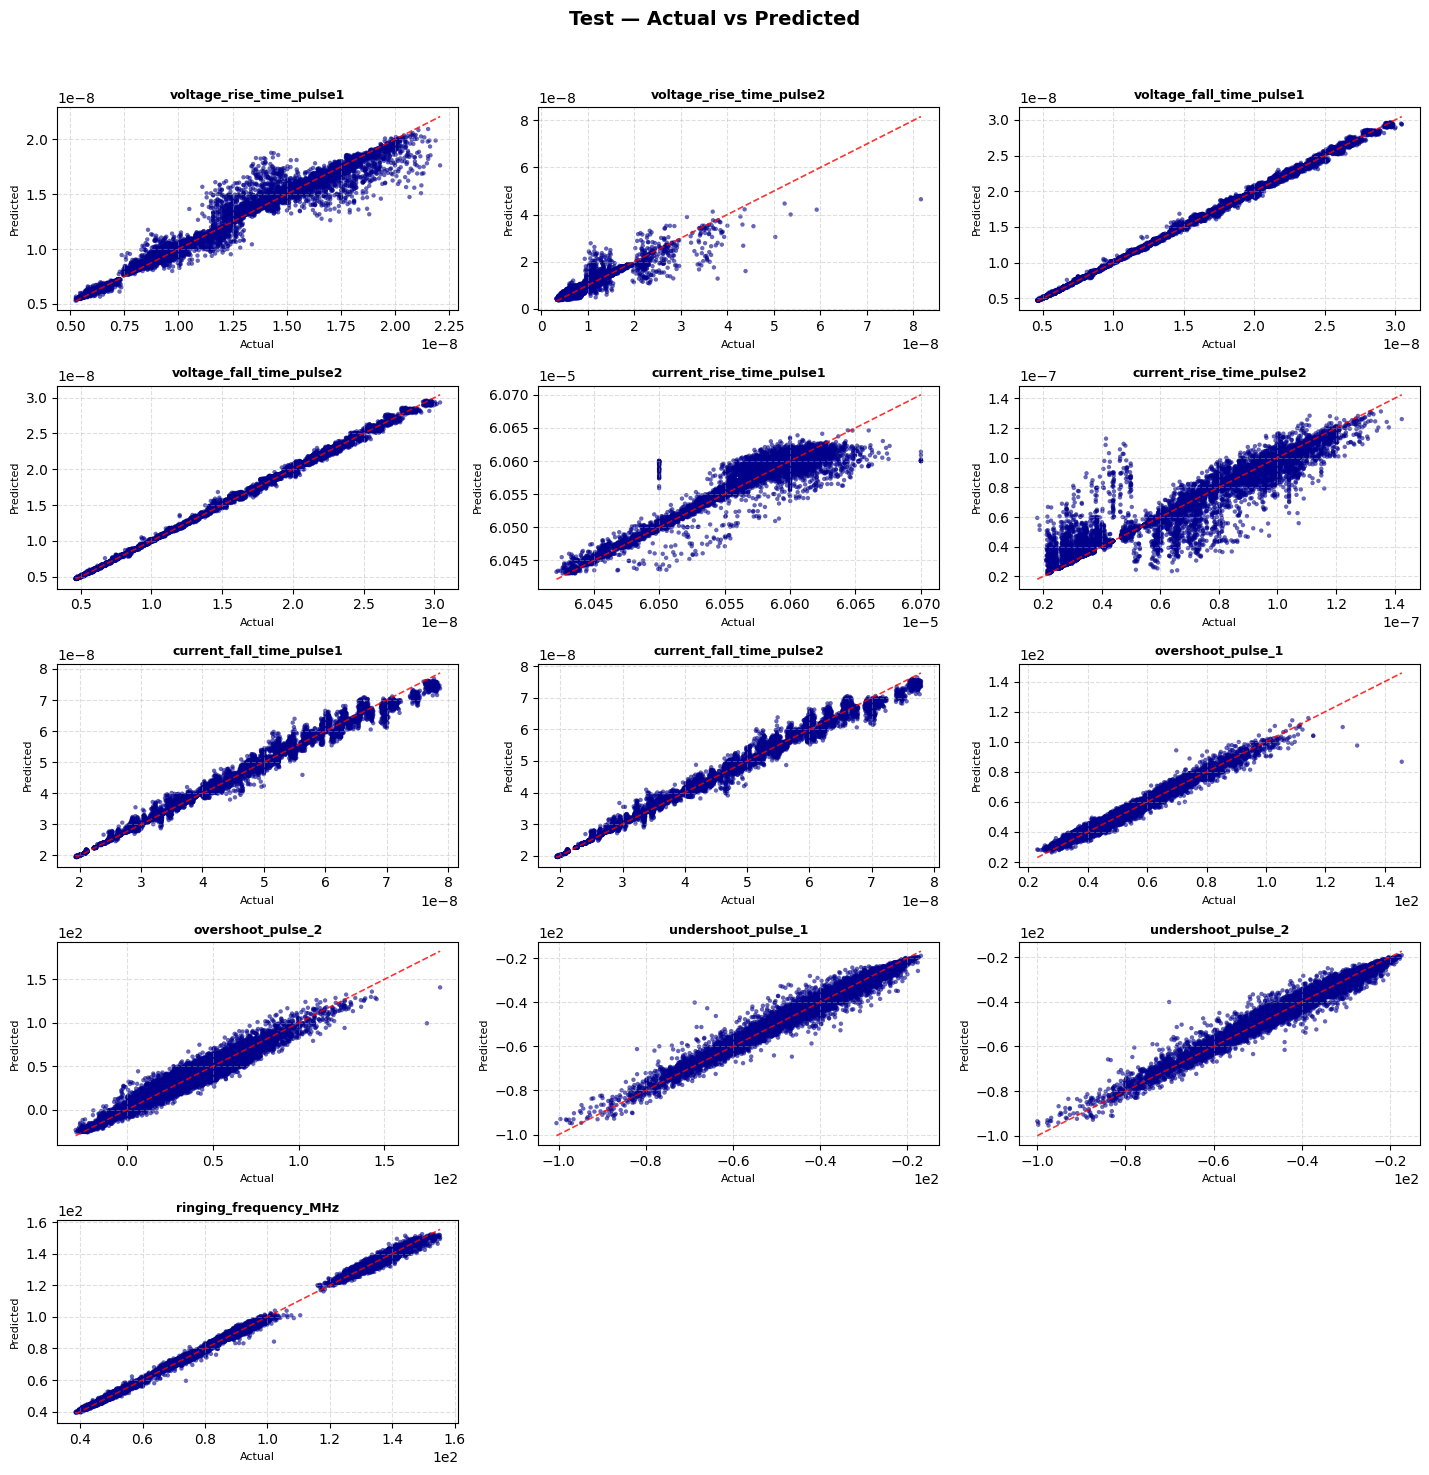

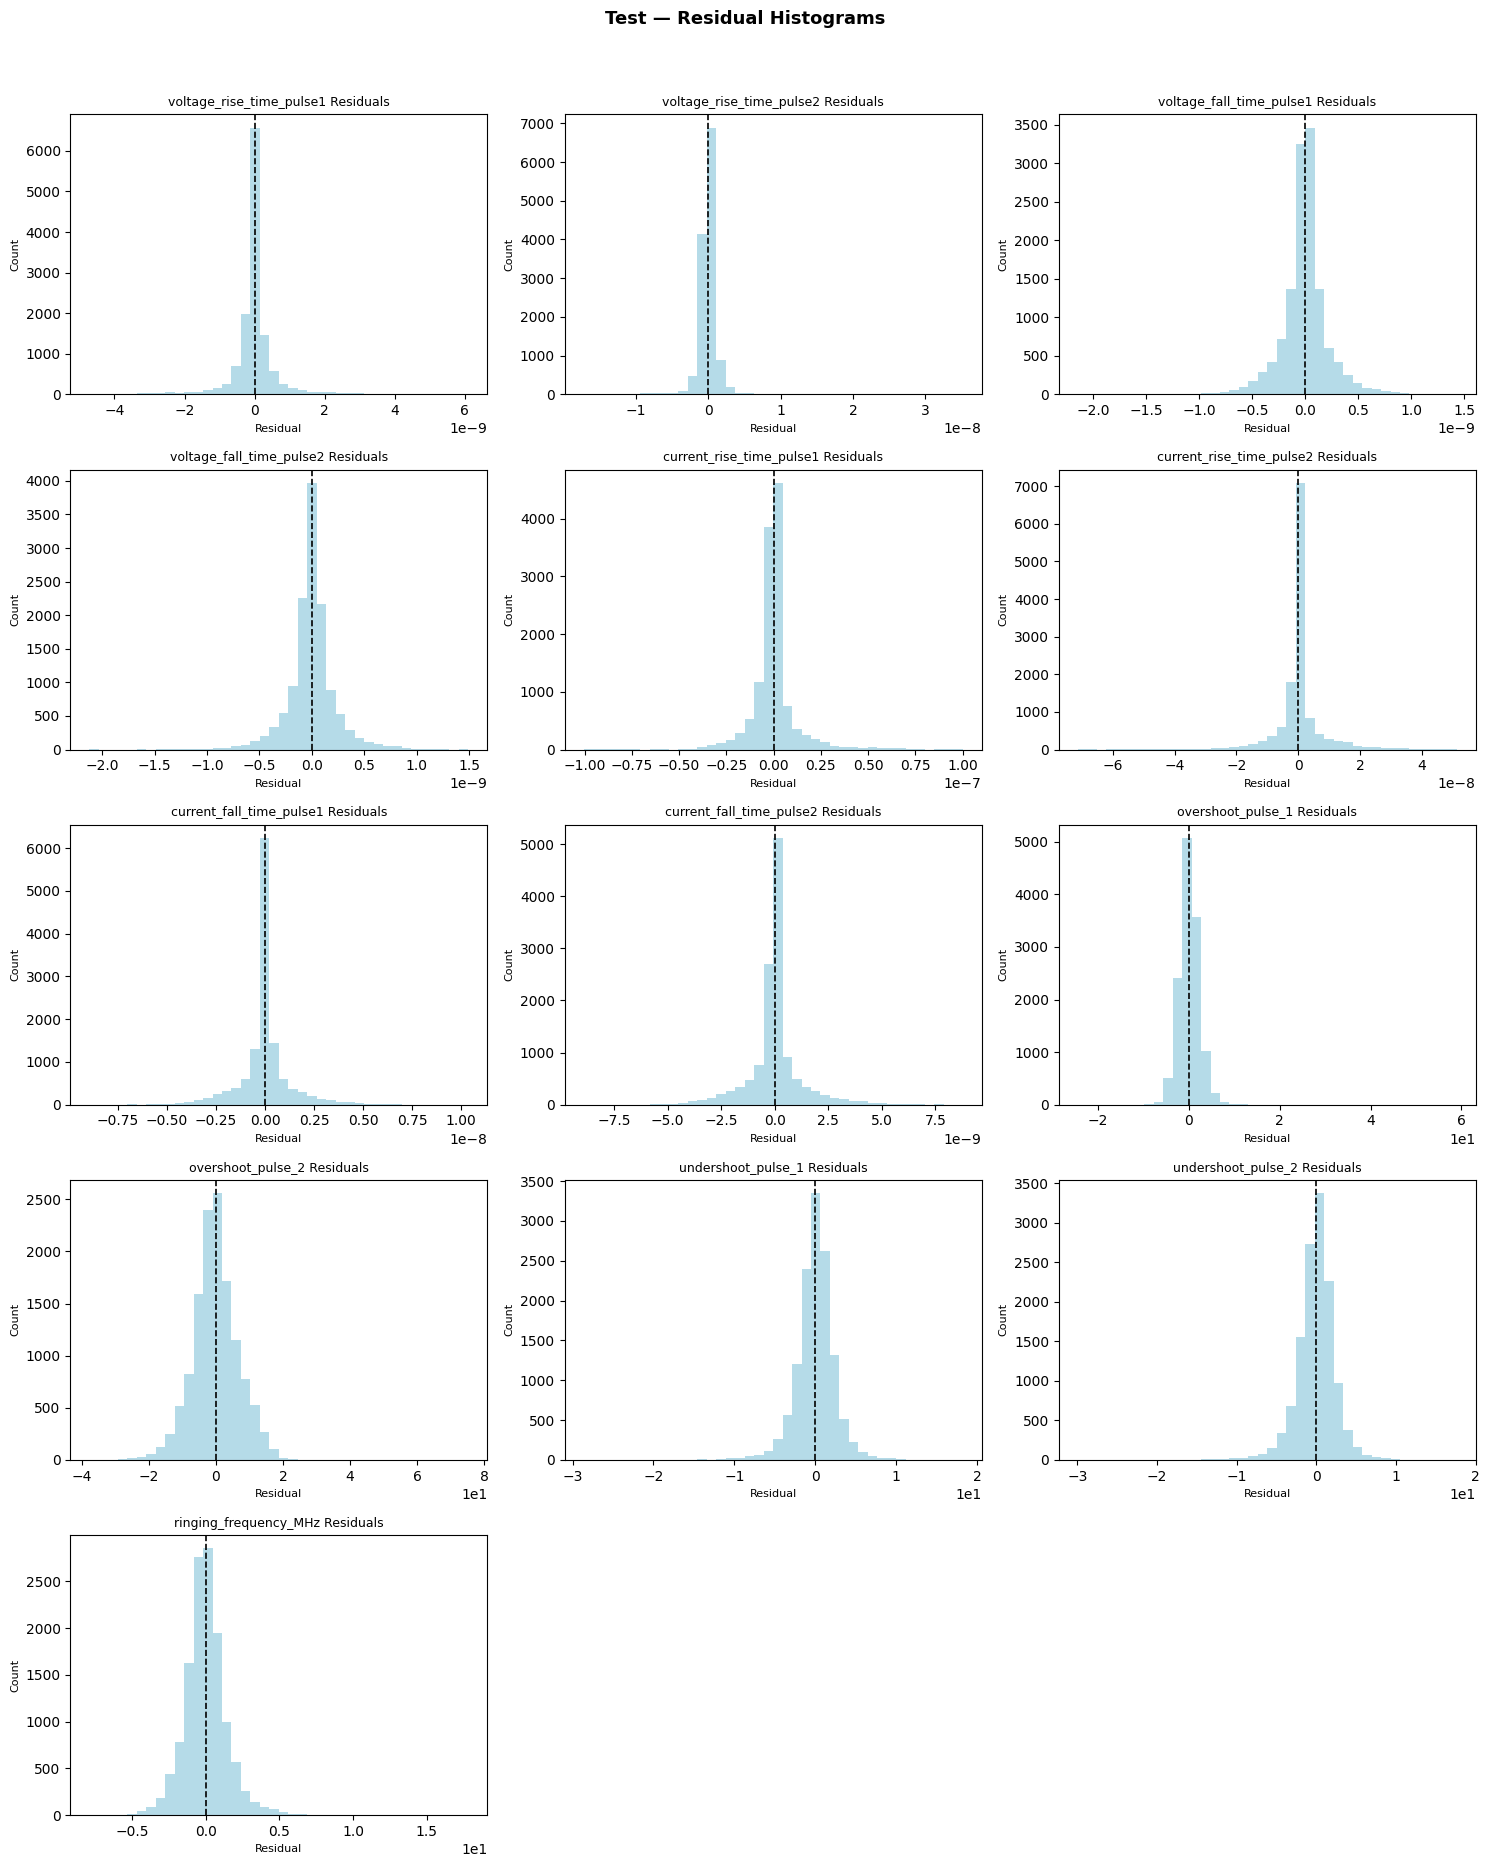

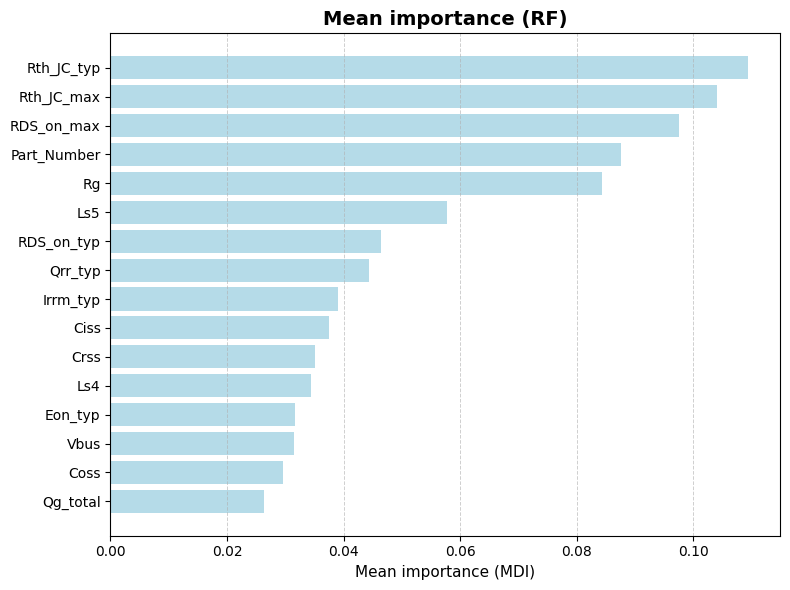

In [2]:
# rf_baseline_complete_test_plots.py
# ------------------------------------------------------------
# Random Forest multi-output baseline with:
# - 70/15/15 split
# - fast per-combo sampling
# - metrics (R2, RMSE, MAE)
# - R² bars (Validation vs Test: pink vs light-blue)
# - Scatter grid (TEST ONLY, darkblue + red dashed 45°)
# - Residual histograms (TEST ONLY, light-blue + dashed zero line)
# - Mean RF importance (light-blue)
# ------------------------------------------------------------

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ===================== Config =====================
TRAIN_FILE  = r"C:\Users\pc\Desktop\Classical_Models\MERGED_ORIGINAL\Train_5_MOSFETs.csv"
RANDOM_STATE = 42
FAST_FRAC    = 0.25       # 25% per (Vbus..Ls11) combo
GRID_COLS    = 3          # columns in scatter/residual grids
TOP_K_IMPORT = 16         # top features for importance plot
# ==================================================

TARGETS = [
    'voltage_rise_time_pulse1','voltage_rise_time_pulse2',
    'voltage_fall_time_pulse1','voltage_fall_time_pulse2',
    'current_rise_time_pulse1','current_rise_time_pulse2',
    'current_fall_time_pulse1','current_fall_time_pulse2',
    'overshoot_pulse_1','overshoot_pulse_2',
    'undershoot_pulse_1','undershoot_pulse_2',
    'ringing_frequency_MHz'
]
COMBO_COLS = ["Vbus","Rg","Ls4","Ls5","Ls6","Ls7","Ls8","Ls9","Ls10","Ls11"]

# ---------- helpers ----------
def encode_part_number(df):
    if "Part_Number" in df.columns:
        le = LabelEncoder()
        df["Part_Number"] = le.fit_transform(df["Part_Number"].astype(str))
    return df

def sample_by_combo(df, combo_cols, frac=0.25, random_state=42):
    """Sample a fraction within each unique combo (fast, no groupby.apply)."""
    if frac >= 1.0:
        return df.reset_index(drop=True)
    rng = np.random.default_rng(random_state)
    parts = []
    for _, g in df.groupby(combo_cols, dropna=False, sort=False):
        n = max(1, int(round(frac * len(g))))
        n = min(n, len(g))
        idx = rng.choice(g.index.to_numpy(), size=n, replace=False)
        parts.append(df.loc[idx])
    out = pd.concat(parts, axis=0).sort_index().reset_index(drop=True)
    return out

def split_70_15_15(X, y, seed=RANDOM_STATE):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, random_state=seed, shuffle=True
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=seed, shuffle=True
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

def train_rf(X_train, y_train, seed=RANDOM_STATE):
    model = RandomForestRegressor(
        n_estimators=200,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=seed
    )
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0
    return model, train_time

def predict_with_timing(model, X):
    t0 = time.time()
    y_pred = model.predict(X)
    ms_per_sample = (time.time() - t0) / len(X) * 1000.0
    return y_pred, ms_per_sample

def compute_metrics(y_true, y_pred):
    rows = []
    for i, t in enumerate(TARGETS):
        yt, yp = y_true[:, i], y_pred[:, i]
        r2  = r2_score(yt, yp)
        rmse = np.sqrt(mean_squared_error(yt, yp))
        mae  = mean_absolute_error(yt, yp)
        rows.append([t, r2, rmse, mae])
    df = pd.DataFrame(rows, columns=["Target", "R2", "RMSE", "MAE"])
    overall = {
        "R2_avg":  r2_score(y_true, y_pred, multioutput="uniform_average"),
        "RMSE_avg":np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE_avg": mean_absolute_error(y_true, y_pred),
    }
    return df, overall

def format_metrics(df_metrics, overall):
    df_fmt = df_metrics.copy()
    df_fmt["R2"]   = df_fmt["R2"].map(lambda x: f"{x:.4f}")
    df_fmt["RMSE"] = df_fmt["RMSE"].map(lambda x: f"{x:.4e}")
    df_fmt["MAE"]  = df_fmt["MAE"].map(lambda x: f"{x:.4e}")
    overall_fmt = {
        "R2_avg":  f"{overall['R2_avg']:.4f}",
        "RMSE_avg":f"{overall['RMSE_avg']:.4e}",
        "MAE_avg": f"{overall['MAE_avg']:.4e}",
    }
    return df_fmt, overall_fmt

# ---------- plots ----------
def plot_r2_bars(val_df: pd.DataFrame, test_df: pd.DataFrame):
    """Grouped R² bars for Val vs Test with your palette."""
    targets = val_df["Target"].tolist()
    x = np.arange(len(targets))
    width = 0.35

    fig, ax = plt.subplots(figsize=(max(10, 0.6*len(targets)), 5))
    ax.bar(x - width/2, val_df["R2"].values,  width,
           label="Validation", color="#ffb6c1", alpha=0.85)  # light pink
    ax.bar(x + width/2, test_df["R2"].values, width,
           label="Test", color="#add8e6", alpha=0.85)        # light blue

    ax.set_xticks(x)
    ax.set_xticklabels(targets, rotation=45, ha="right", fontsize=9)
    ax.set_ylabel("R²", fontsize=11)
    ax.set_title("Per-target R²: Validation vs Test", fontsize=13, weight="bold")
    ax.set_ylim(0.6, 1.0)  # adjust to taste
    ax.grid(axis='y', linestyle='--', alpha=0.6, linewidth=0.7)
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

def scatter_grid_test_only(y_true, y_pred, target_names, n_cols=GRID_COLS):
    """TEST ONLY: Actual vs Predicted scatter (darkblue points)."""
    n_targets = len(target_names)
    n_rows = int(np.ceil(n_targets / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.8*n_cols, 3.0*n_rows))
    axes = axes.flatten()

    for i, t in enumerate(target_names):
        ax = axes[i]
        ax.scatter(y_true[:, i], y_pred[:, i], s=10, alpha=0.6,
                   color="darkblue", edgecolors="none")
        mn = min(y_true[:, i].min(), y_pred[:, i].min())
        mx = max(y_true[:, i].max(), y_pred[:, i].max())
        ax.plot([mn, mx], [mn, mx], '--', lw=1.2, color="red", alpha=0.8)  # perfect fit
        ax.set_title(t, fontsize=9, weight="bold")
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
        ax.set_xlabel("Actual", fontsize=8)
        ax.set_ylabel("Predicted", fontsize=8)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Test — Actual vs Predicted", fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_residual_histograms_test_only(y_true, y_pred, target_names):
    """TEST ONLY: Residual histogram grid with light-blue bars + dashed zero line."""
    residuals = y_true - y_pred
    n_targets = len(target_names)
    n_cols = GRID_COLS
    n_rows = int(np.ceil(n_targets / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3.8*n_rows))
    axes = axes.flatten()

    for i, t in enumerate(target_names):
        ax = axes[i]
        ax.hist(residuals[:, i], bins=40, color="#add8e6", alpha=0.9)
        ax.axvline(0, color='black', linestyle='--', linewidth=1.2)  # zero line
        ax.set_title(f"{t} Residuals", fontsize=9)
        ax.set_xlabel("Residual", fontsize=8)
        ax.set_ylabel("Count", fontsize=8)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.grid(False)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Test — Residual Histograms", fontsize=13, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_mean_importance_rf(model, feature_names, top_k=16):
    """Mean feature importance from RandomForest (MDI), light-blue horizontal bars."""
    imp = model.feature_importances_
    imp_df = pd.DataFrame({"feature": feature_names, "importance": imp})
    imp_df = imp_df.sort_values("importance", ascending=False).head(top_k).iloc[::-1]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(imp_df["feature"], imp_df["importance"], color="#add8e6", alpha=0.9)
    ax.set_title("Mean importance (RF)", fontsize=14, weight="bold")
    ax.set_xlabel("Mean importance (MDI)", fontsize=11)
    ax.set_ylabel("")
    ax.grid(axis="x", linestyle="--", alpha=0.6, linewidth=0.7)
    plt.tight_layout()
    plt.show()

# ----------------- main -----------------
def main():
    # Load & prep (seen data only)
    df = pd.read_csv(TRAIN_FILE).dropna().reset_index(drop=True)
    df = encode_part_number(df)

    # Fast (balanced) sample per (Vbus..Ls11) combo
    df_fast = sample_by_combo(df, COMBO_COLS, frac=FAST_FRAC, random_state=RANDOM_STATE)
    print(f"[INFO] FAST sample: {len(df_fast)} rows (from {len(df)})")

    # Build X, y
    feature_cols = [c for c in df_fast.columns if c not in TARGETS]
    X = df_fast[feature_cols].values
    y = df_fast[TARGETS].values

    # 70/15/15 split
    X_tr, X_va, X_te, y_tr, y_va, y_te = split_70_15_15(X, y)

    # Train RF + timings
    model, train_time = train_rf(X_tr, y_tr)

    # ---------- Validation ----------
    y_va_pred, va_ms = predict_with_timing(model, X_va)
    va_metrics, va_overall = compute_metrics(y_va, y_va_pred)
    va_metrics_fmt, va_overall_fmt = format_metrics(va_metrics, va_overall)

    print("\n=== Validation Set ===")
    print(va_metrics_fmt.to_string(index=False))
    print(pd.Series(va_overall_fmt))
    print(f"Train Time (s): {train_time:.4f}")
    print(f"Predict Time (ms/sample): {va_ms:.4f}")

    # ---------- Test ----------
    y_te_pred, te_ms = predict_with_timing(model, X_te)
    te_metrics, te_overall = compute_metrics(y_te, y_te_pred)
    te_metrics_fmt, te_overall_fmt = format_metrics(te_metrics, te_overall)

    print("\n=== Test Set ===")
    print(te_metrics_fmt.to_string(index=False))
    print(pd.Series(te_overall_fmt))
    print(f"Predict Time (ms/sample): {te_ms:.4f}")

    # ---------- Plots ----------
    # R² bars (pink vs light-blue) — Validation vs Test
    plot_r2_bars(va_metrics, te_metrics)

    # Scatter grid — TEST ONLY
    scatter_grid_test_only(y_te, y_te_pred, TARGETS, n_cols=GRID_COLS)

    # Residual histograms — TEST ONLY
    plot_residual_histograms_test_only(y_te, y_te_pred, TARGETS)

    # Mean RF importance (light-blue)
    plot_mean_importance_rf(model, feature_cols, top_k=TOP_K_IMPORT)

if __name__ == "__main__":
    main()
